In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from utils3d import longitudeaxistrue, latitudeaxistrue, log10eaxistrue

# %matplotlib inline
from IPython.display import display
from gammapy.datasets import Datasets, MapDataset
from gammapy.modeling.models import (
    FoVBackgroundModel,
    Models,
    PowerLawNormSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    create_fermi_isotropic_diffuse_model,
)


# %matplotlib inline
import numpy as np
from gammapy.maps import Map, MapAxis, MapAxes, WcsGeom
from scipy import interpolate
from scipy.integrate import simps
from scipy import special
from matplotlib.colors import LogNorm


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def powerlaw(energy, index, phi0=1):
    return phi0*energy**(index)

In [3]:
print(longitudeaxistrue, latitudeaxistrue, log10eaxistrue)

[-3.5        -3.29411765 -3.08823529 -2.88235294 -2.67647059 -2.47058824
 -2.26470588 -2.05882353 -1.85294118 -1.64705882 -1.44117647 -1.23529412
 -1.02941176 -0.82352941 -0.61764706 -0.41176471 -0.20588235  0.
  0.20588235  0.41176471  0.61764706  0.82352941  1.02941176  1.23529412
  1.44117647  1.64705882  1.85294118  2.05882353  2.26470588  2.47058824
  2.67647059  2.88235294  3.08823529  3.29411765  3.5       ] [-3.         -2.79310345 -2.5862069  -2.37931034 -2.17241379 -1.96551724
 -1.75862069 -1.55172414 -1.34482759 -1.13793103 -0.93103448 -0.72413793
 -0.51724138 -0.31034483 -0.10344828  0.10344828  0.31034483  0.51724138
  0.72413793  0.93103448  1.13793103  1.34482759  1.55172414  1.75862069
  1.96551724  2.17241379  2.37931034  2.5862069   2.79310345  3.        ] [-8.00000000e-01 -7.90000000e-01 -7.80000000e-01 -7.70000000e-01
 -7.60000000e-01 -7.50000000e-01 -7.40000000e-01 -7.30000000e-01
 -7.20000000e-01 -7.10000000e-01 -7.00000000e-01 -6.90000000e-01
 -6.80000000e-01 -6.

# HESS GPS Sources

In [4]:
from gammapy.catalog import SourceCatalogHGPS


hess_catalog = SourceCatalogHGPS("hgps_catalog_v1.fits.gz")

hess_models = hess_catalog.to_models()

print(f"\nThere are {len(hess_models)} sources within the HGPS.")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)



There are 96 sources within the HGPS.


In [5]:


trueenergyaxis = 10**log10eaxistrue*u.TeV

energy_axis_true = MapAxis.from_nodes(trueenergyaxis, interp='log', name="energy_true")

goodgeom = WcsGeom.create(
    skydir=SkyCoord(0, 0, unit="deg", frame='galactic'),
    binsz=longitudeaxistrue[1]-longitudeaxistrue[0],
    width=(longitudeaxistrue[-1]-longitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0], latitudeaxistrue[-1]-latitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0]),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis_true],
)

goodmap = Map.from_geom(goodgeom)
goodmap

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (35, 30, 231)
	ndim  : 3
	unit  : 
	dtype : float32

In [6]:
hessenergyaxis = energy_axis_true.center.value
np.log10(hessenergyaxis[1:]-hessenergyaxis[:-1])

array([-2.43277472, -2.42277472, -2.41277472, -2.40277472, -2.39277472,
       -2.38277472, -2.37277472, -2.36277472, -2.35277472, -2.34277472,
       -2.33277472, -2.32277472, -2.31277472, -2.30277472, -2.29277472,
       -2.28277472, -2.27277472, -2.26277472, -2.25277472, -2.24277472,
       -2.23277472, -2.22277472, -2.21277472, -2.20277472, -2.19277472,
       -2.18277472, -2.17277472, -2.16277472, -2.15277472, -2.14277472,
       -2.13277472, -2.12277472, -2.11277472, -2.10277472, -2.09277472,
       -2.08277472, -2.07277472, -2.06277472, -2.05277472, -2.04277472,
       -2.03277472, -2.02277472, -2.01277472, -2.00277472, -1.99277472,
       -1.98277472, -1.97277472, -1.96277472, -1.95277472, -1.94277472,
       -1.93277472, -1.92277472, -1.91277472, -1.90277472, -1.89277472,
       -1.88277472, -1.87277472, -1.86277472, -1.85277472, -1.84277472,
       -1.83277472, -1.82277472, -1.81277472, -1.80277472, -1.79277472,
       -1.78277472, -1.77277472, -1.76277472, -1.75277472, -1.74

In [7]:

# fig, ax = plt.subplots(2,4, figsize=(8,3))


# m = Map.create(skydir=(0, 0), width=(10, 10), binsz=0.1, frame="galactic")
m= goodmap
count=0
fullhessdataset = 0
for idx, model in enumerate(hess_models):
    templvalue = model.spatial_model.position.l.value
    tempbvalue = model.spatial_model.position.b.value
    
    if templvalue>180:
        templvalue=templvalue-360
    
    if np.abs(templvalue)<5 and np.abs(tempbvalue)<5:
        print(templvalue, tempbvalue, idx)
        try:
            m.quantity = model.evaluate_geom(m.geom)
            print(model.name)
            # m.plot(ax=ax[count//4, count%4], add_cbar=True)
            startdata = m.data
            data = startdata[~np.isnan(startdata)]
            if data.size!=0:
                data = data.reshape(startdata.shape)
                fullhessdataset+=data
            
        except:
            print("Something weird happened")
            print(idx, '\n\n')
        count+=1
# plt.show()
fullhessdataset = np.transpose(fullhessdataset, axes=(0,2,1))

-1.723175048828125 0.04908088967204094 46
HESS J1741-302
-0.05511474609375 -0.043911051005125046 47
HESS J1745-290
-1.35516357421875 -0.5642170310020447 48
HESS J1745-303
0.14000000059604645 -0.11400000005960464 49
HESS J1746-285
-1.551788330078125 -1.1144022941589355 50
HESS J1746-308
3.779721736907959 1.714707851409912 51
HESS J1747-248
0.871999979019165 0.07599999755620956 52
HESS J1747-281


In [8]:
150*500*500/250000

150.0

In [9]:
hessgeom = goodmap.geom
hesslonvals = hessgeom.get_coord().lon.value[0][0]
hesslonvals = hesslonvals[::-1]
hesslonvals[hesslonvals>180] = hesslonvals[hesslonvals>180]-360
# print("lon vals", hesslonvals)

hesslatvals = hessgeom.get_coord().lat.value[0][:,0]
# print("lat vals", hesslatvals)
print(hesslonvals.shape)
print(hesslatvals.shape)

(35,)
(30,)


In [10]:
m.quantity.unit

Unit("1 / (cm2 s sr TeV)")

In [11]:
fullhessdataset[0,0,0]

1.352971797224967e-205

(35,) (30,) (35, 30)


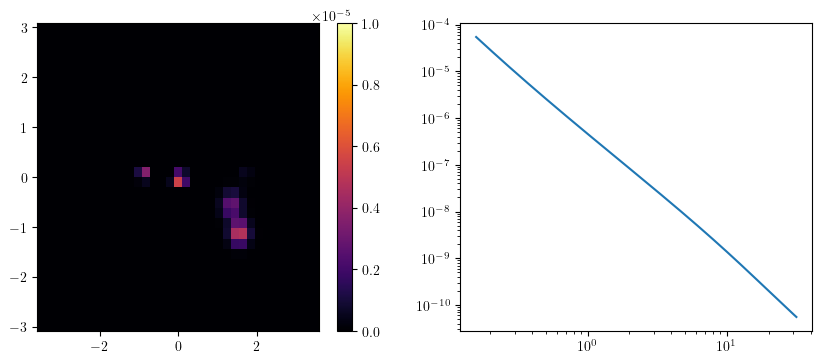

In [12]:
from scipy.ndimage import gaussian_filter

blurred_hess_data = fullhessdataset
print(hesslonvals.shape, hesslatvals.shape, blurred_hess_data[0].shape)
# Factor of 1e6 is so it matches with fermi backgrounds which are 1/MeV
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.pcolormesh(hesslonvals, 
               hesslatvals, 
               np.max(blurred_hess_data, axis=0).T, cmap='inferno', vmax=1e-5)
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(hessenergyaxis,  np.sum(blurred_hess_data, axis=(1,2)))
plt.loglog()
plt.show()

# Fermi-LAT Diffuse Background Extraction

In [13]:
# template_diffuse = TemplateSpatialModel.read(
#     filename="gll_iem_v06_gc.fits.gz", normalize=False
# )

template_diffuse = TemplateSpatialModel.read(
    filename="gll_iem_v07.fits", normalize=False
)

print(template_diffuse.map)

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
)

template_diffuse

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (2880, 1441, 28)
	ndim  : 3
	unit  : 1 / (cm2 MeV s sr)
	dtype : >f4



In [14]:
fermievaluated = np.flip(np.transpose(diffuse_iem.evaluate_geom(goodgeom), axes=(0,2,1)), axis=1)
fermiaveraged = special.logsumexp(np.log(fermievaluated.value.T)+10**log10eaxistrue+np.log(np.log(10))+log10eaxistrue[1]-log10eaxistrue[0], axis=2).T
fermiaveraged.shape

fermiaveraged = fermiaveraged-special.logsumexp(fermiaveraged+np.log(longitudeaxistrue[1]-longitudeaxistrue[0])+np.log(latitudeaxistrue[1]-latitudeaxistrue[0]))
fermifull = np.exp(fermiaveraged[np.newaxis, :, :]+np.log(powerlaw(10**log10eaxistrue, index=-2.41, phi0=1.36*1e-8))[:, np.newaxis, np.newaxis])
fermifull.shape

(231, 35, 30)

In [15]:
fermifull[1,0]

array([7.88507014e-09, 8.56950733e-09, 8.89322938e-09, 9.56676567e-09,
       1.02414013e-08, 1.11097077e-08, 1.20421282e-08, 1.29199541e-08,
       1.35654146e-08, 1.46344942e-08, 1.76811524e-08, 2.29777052e-08,
       2.79023432e-08, 4.23859885e-08, 5.32735906e-08, 6.09502234e-08,
       5.75263100e-08, 4.71629048e-08, 3.81798986e-08, 3.30323646e-08,
       3.37101276e-08, 2.91271626e-08, 2.04634798e-08, 1.50740960e-08,
       1.36123369e-08, 1.24120384e-08, 1.18144288e-08, 1.11537561e-08,
       9.87352853e-09, 9.33753228e-09])

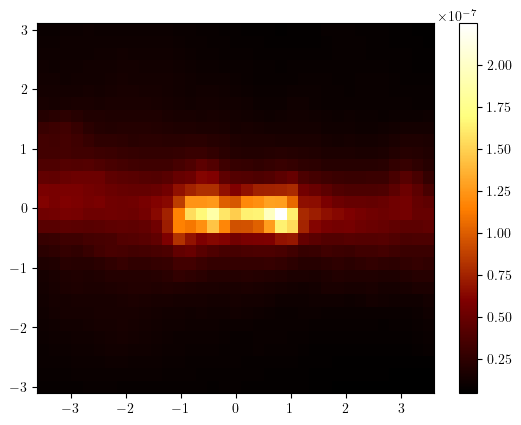

In [16]:
plt.figure()
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, fermifull[1].T, cmap='afmhot')
plt.colorbar()
plt.show()

In [17]:
fermievaluated = fermievaluated.to(1/u.TeV/u.s/u.sr/(u.cm**2))

In [18]:
fermievaluated[0,0,0]

<Quantity 1.48894384e-07 1 / (cm2 s sr TeV)>

In [19]:
fermilonaxistemp = np.unique(goodgeom.to_image().get_coord().lon.value)
firstover180idx = np.where(fermilonaxistemp>180)[0][0]
fermilonaxistemp[fermilonaxistemp>180] = fermilonaxistemp[fermilonaxistemp>180]-360
fermilonaxistemp.sort()
fermilonaxistemp.shape
fermilonaxis = fermilonaxistemp
fermilonaxis

array([-3.5       , -3.29411765, -3.08823529, -2.88235294, -2.67647059,
       -2.47058824, -2.26470588, -2.05882353, -1.85294118, -1.64705882,
       -1.44117647, -1.23529412, -1.02941176, -0.82352941, -0.61764706,
       -0.41176471, -0.20588235,  0.        ,  0.20588235,  0.41176471,
        0.61764706,  0.82352941,  1.02941176,  1.23529412,  1.44117647,
        1.64705882,  1.85294118,  2.05882353,  2.26470588,  2.47058824,
        2.67647059,  2.88235294,  3.08823529,  3.29411765,  3.5       ])

In [20]:
fermilataxis = goodgeom.get_coord().lat.value[0][:,0]
fermilataxis

array([-2.98529412, -2.77941176, -2.57352941, -2.36764706, -2.16176471,
       -1.95588235, -1.75      , -1.54411765, -1.33823529, -1.13235294,
       -0.92647059, -0.72058824, -0.51470588, -0.30882353, -0.10294118,
        0.10294118,  0.30882353,  0.51470588,  0.72058824,  0.92647059,
        1.13235294,  1.33823529,  1.54411765,  1.75      ,  1.95588235,
        2.16176471,  2.36764706,  2.57352941,  2.77941176,  2.98529412])

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


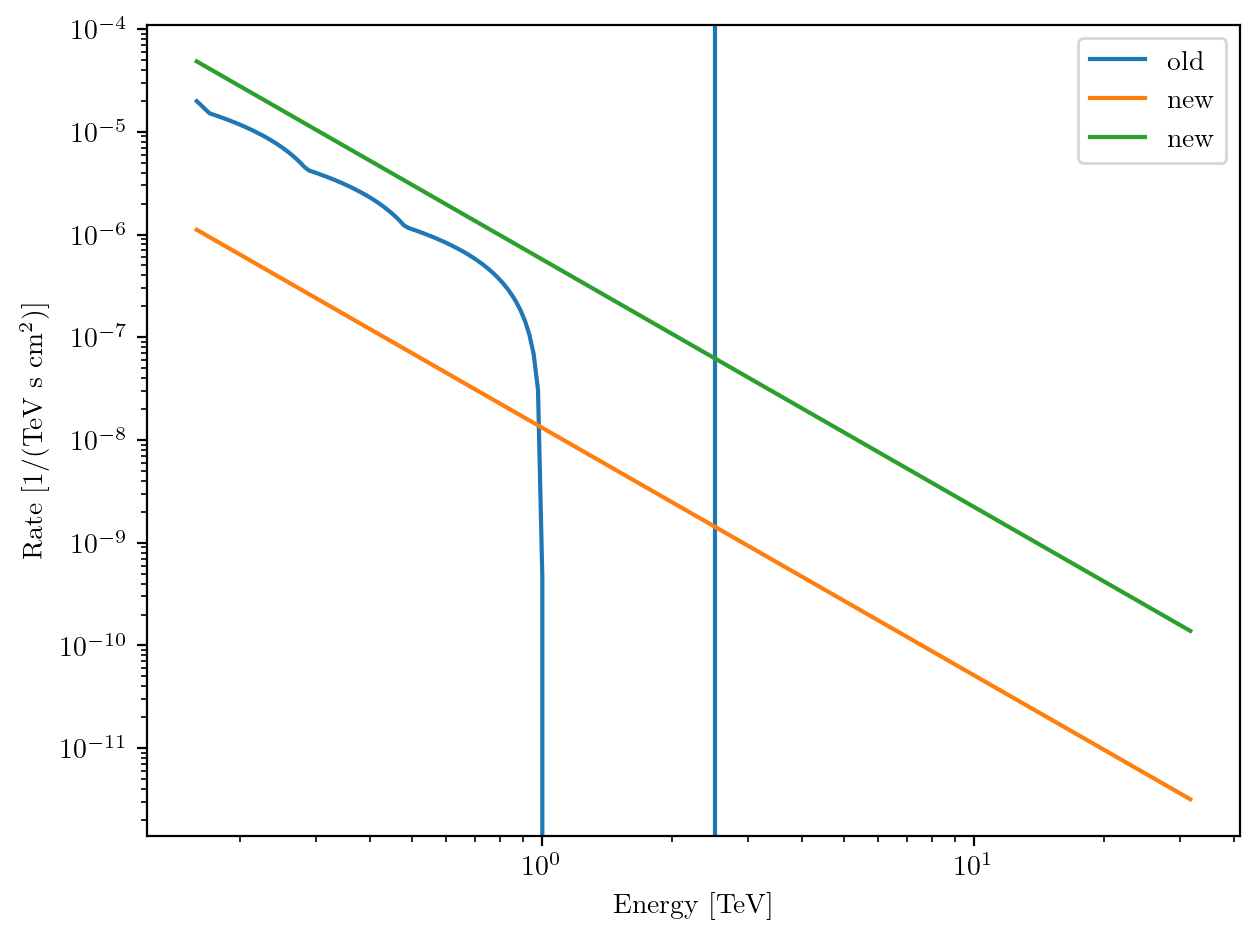

In [21]:

plt.figure(dpi=200)
cutoff = 120
vals = simps(y=simps(y=fermievaluated[:cutoff,:,:], x= longitudeaxistrue, axis=1), x = latitudeaxistrue, axis=1)
fit = interpolate.interp1d(y=np.log(vals), x=log10eaxistrue[:cutoff], bounds_error=False, fill_value='extrapolate')
# plt.plot(10**log10eaxistrue[:cutoff], vals)
plt.plot(10**log10eaxistrue, np.exp(fit(log10eaxistrue)), label='old')
plt.axvline(10**log10eaxistrue[cutoff])
plt.plot(10**log10eaxistrue, simps(y=simps(y=fermifull, x= longitudeaxistrue, axis=1), x = latitudeaxistrue, axis=1), label='new')
plt.plot(10**log10eaxistrue, powerlaw(10**log10eaxistrue, index=-2.41, phi0=1.36*1e-8)*(longitudeaxistrue[-1]-longitudeaxistrue[0])*(latitudeaxistrue[-1]-latitudeaxistrue[0]), label='new')
plt.loglog()
plt.xlabel('Energy [TeV]')
plt.ylabel(r'Rate [1/(TeV s cm$^2$)]')
plt.legend()
plt.tight_layout()
plt.show()

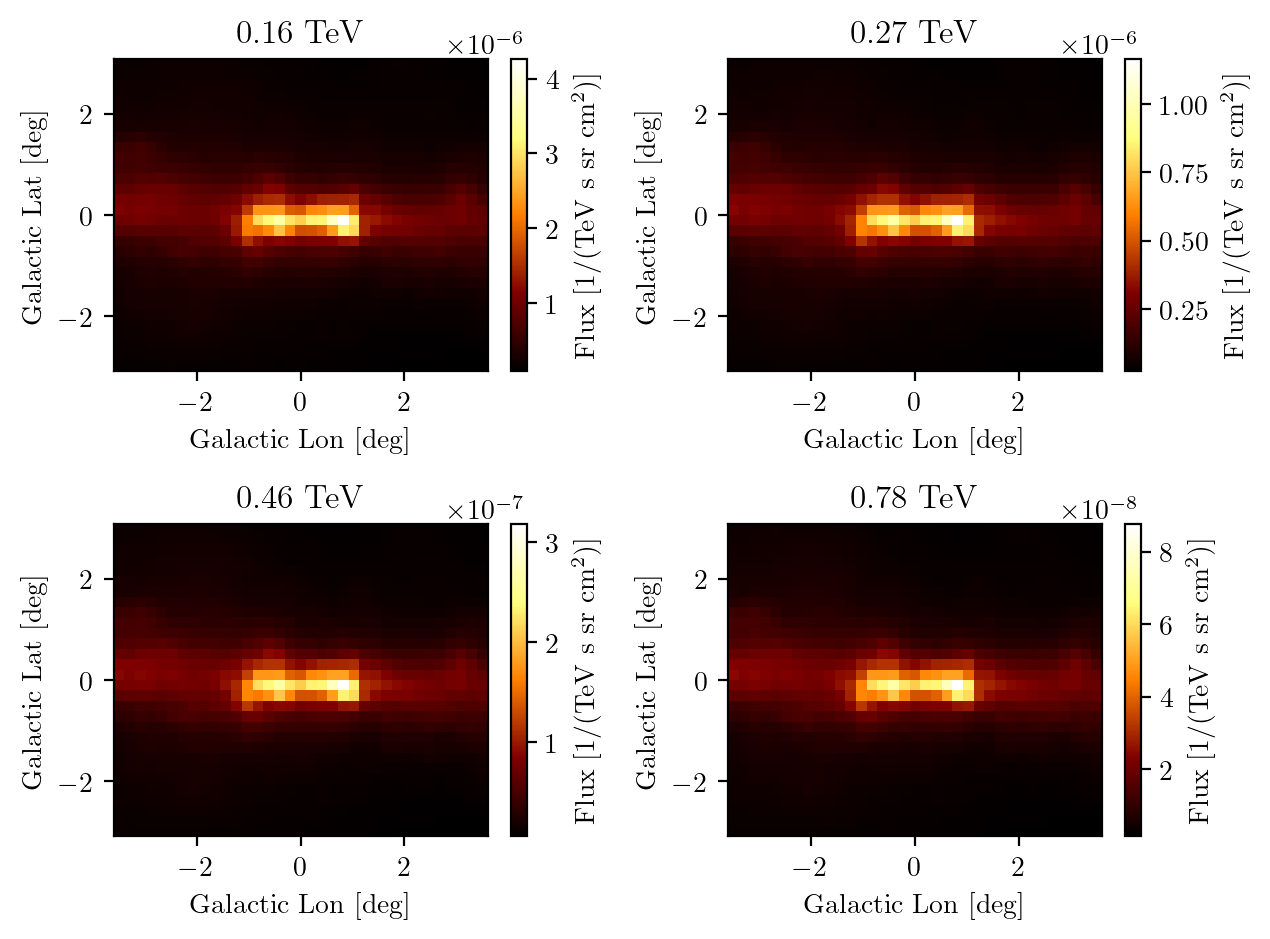

In [22]:

plt.figure(dpi=200)

counter=1
for idx in np.arange(0, log10eaxistrue.shape[0], int(log10eaxistrue.shape[0]/10)):
    plt.subplot(2,2,counter)
    plt.title(f'{round(10**log10eaxistrue[idx],2)} TeV')
    plt.pcolormesh(fermilonaxis, fermilataxis, fermievaluated[idx].T, cmap='afmhot')
    plt.colorbar(label=r'Flux [1/(TeV s sr cm$^2$)]')
    plt.xlabel('Galactic Lon [deg]')
    plt.ylabel('Galactic Lat [deg]')
    counter+=1
    if counter>4:
        break

plt.tight_layout()
plt.show()

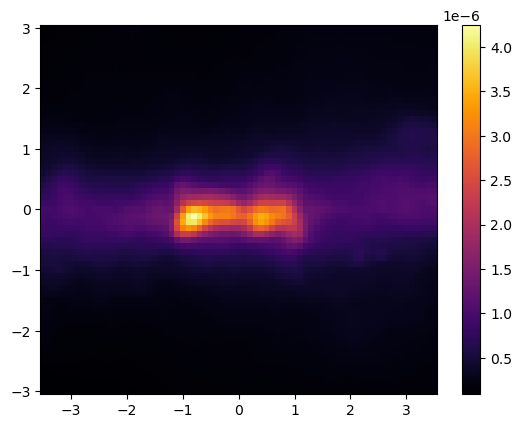

In [23]:
fermiunit = fermievaluated.unit
fermiunit

Unit("1 / (cm2 s sr TeV)")

In [24]:
fermienergyvals = energy_axis_true.center.value
fermienergyvals

array([ 0.15848932,  0.16218101,  0.16595869,  0.16982437,  0.17378008,
        0.17782794,  0.18197009,  0.18620871,  0.19054607,  0.19498446,
        0.19952623,  0.20417379,  0.20892961,  0.21379621,  0.21877616,
        0.22387211,  0.22908677,  0.23442288,  0.23988329,  0.24547089,
        0.25118864,  0.25703958,  0.2630268 ,  0.26915348,  0.27542287,
        0.28183829,  0.28840315,  0.29512092,  0.30199517,  0.30902954,
        0.31622777,  0.32359366,  0.33113112,  0.33884416,  0.34673685,
        0.35481339,  0.36307805,  0.37153523,  0.3801894 ,  0.38904514,
        0.39810717,  0.40738028,  0.41686938,  0.42657952,  0.43651583,
        0.44668359,  0.45708819,  0.46773514,  0.47863009,  0.48977882,
        0.50118723,  0.51286138,  0.52480746,  0.5370318 ,  0.54954087,
        0.56234133,  0.57543994,  0.58884366,  0.60255959,  0.616595  ,
        0.63095734,  0.64565423,  0.66069345,  0.67608298,  0.69183097,
        0.70794578,  0.72443596,  0.74131024,  0.75857758,  0.77

In [25]:
fermievaluated[0,0,0]

<Quantity 1.48894384e-07 1 / (cm2 s sr TeV)>

# Adding the two astrophysical components together

In [26]:
fermiplotmap = fermievaluated.value
combinedplotmap = fermifull #+ np.flip(fullhessdataset, axis=1)

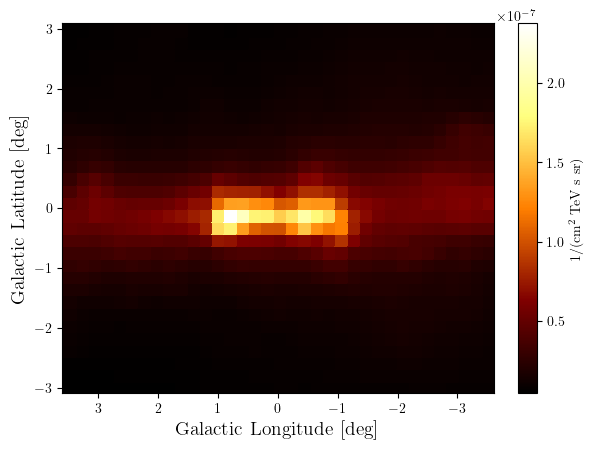

In [85]:


fig6, ax = plt.subplots()
pcol = plt.pcolormesh(fermilonaxis, fermilataxis, np.max(combinedplotmap,axis=0).T, cmap='afmhot', shading='auto')#, norm=LogNorm(vmin=1e-6, vmax=5e-5))
pcol.set_edgecolor('face')

plt.xlabel("Galactic Longitude [deg]", size=14)
ax.invert_xaxis()

plt.ylabel("Galactic Latitude [deg]", size=14)
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(cm$^2$ TeV s sr)")
plt.savefig('Figures/Diffuse_BKG_Spatial_Map.pdf')
plt.show()

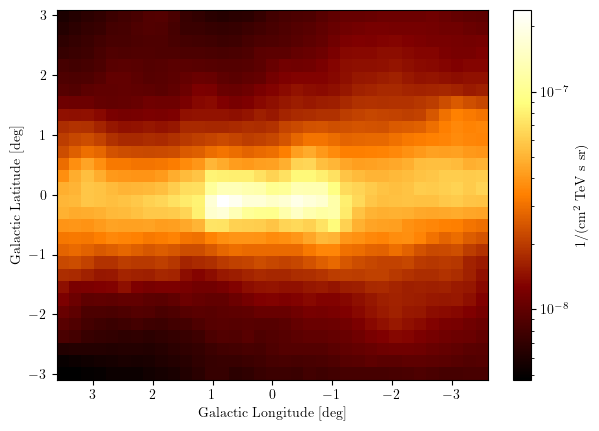

In [28]:
fig6, ax = plt.subplots(dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, np.max(combinedplotmap,axis=0).T, cmap='afmhot', norm=LogNorm())#, vmax=1e-5)
plt.xlabel("Galactic Longitude [deg]")
ax.invert_xaxis()
plt.ylabel("Galactic Latitude [deg]")
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(cm$^2$ TeV s sr)")

plt.show()

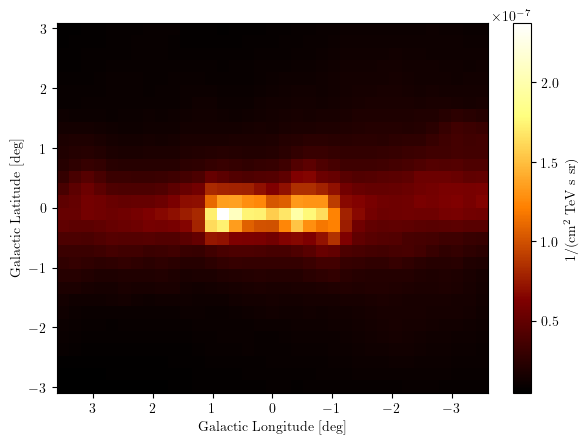

In [29]:
fig6, ax = plt.subplots(dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, np.max(combinedplotmap,axis=0).T, cmap='afmhot')#, vmax=1e-5)
plt.xlabel("Galactic Longitude [deg]")
ax.invert_xaxis()
plt.ylabel("Galactic Latitude [deg]")
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(cm$^2$ TeV s sr)")

plt.show()

In [30]:
combinedplotmap.shape

(231, 35, 30)

In [31]:
from utils3d import irfs

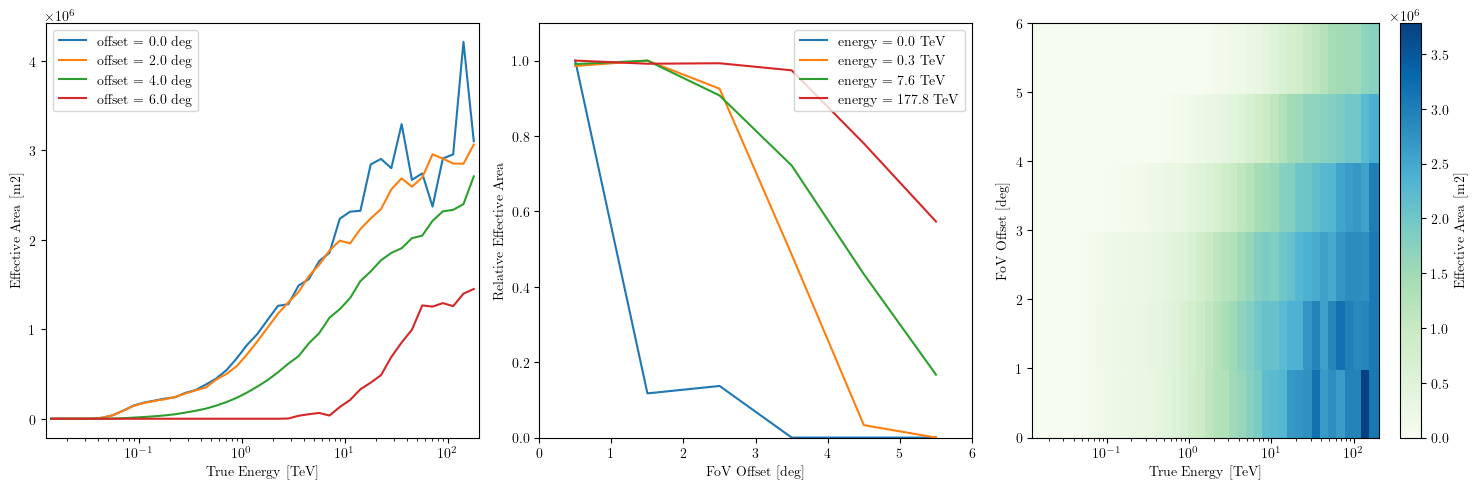

In [32]:
aeff = irfs['aeff']
aeff.peek()

In [33]:
aefffunc = lambda energy, offset: aeff.evaluate(energy_true = energy*u.TeV, offset=offset*u.deg).to(u.cm**2).value

In [34]:
aeff.evaluate(energy_true = 1*u.TeV, offset=0.5*u.deg)/1e5

<Quantity 7.35946814 m2>

In [35]:
aefffunc(1.0, 0.5)/1e9

7.359468135925809

In [36]:
lonmesh, energymesh, latmesh = np.meshgrid(longitudeaxistrue, 10**log10eaxistrue, latitudeaxistrue)
print(lonmesh.shape)

(231, 35, 30)


In [37]:
aefftable = aefffunc(energymesh, np.sqrt((lonmesh**2)+(latmesh**2)))

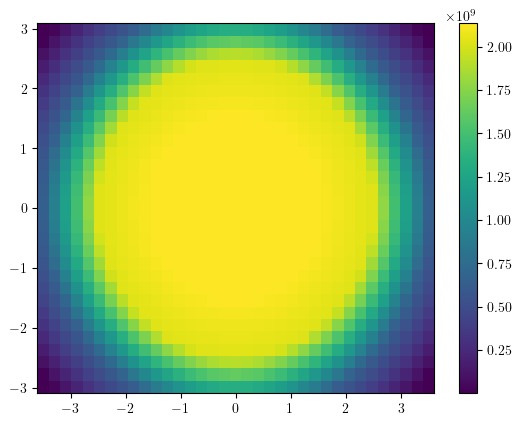

In [38]:
plt.pcolormesh(fermilonaxis, fermilataxis, aefftable[0,:,:].T)
plt.colorbar()
plt.show()

In [39]:
# aefftable[75,250,250]

In [40]:
# fermilataxis[250]

In [41]:
# aefffunc(fermienergyvals[75], np.sqrt(fermilonaxis[250]**2+fermilataxis[250]**2))

In [42]:
np.log(fermienergyvals[1:]-fermienergyvals[:-1])

array([-5.6016708 , -5.57864495, -5.5556191 , -5.53259325, -5.50956739,
       -5.48654154, -5.46351569, -5.44048984, -5.41746399, -5.39443814,
       -5.37141229, -5.34838644, -5.32536059, -5.30233474, -5.27930889,
       -5.25628303, -5.23325718, -5.21023133, -5.18720548, -5.16417963,
       -5.14115378, -5.11812793, -5.09510208, -5.07207623, -5.04905038,
       -5.02602453, -5.00299867, -4.97997282, -4.95694697, -4.93392112,
       -4.91089527, -4.88786942, -4.86484357, -4.84181772, -4.81879187,
       -4.79576602, -4.77274017, -4.74971431, -4.72668846, -4.70366261,
       -4.68063676, -4.65761091, -4.63458506, -4.61155921, -4.58853336,
       -4.56550751, -4.54248166, -4.5194558 , -4.49642995, -4.4734041 ,
       -4.45037825, -4.4273524 , -4.40432655, -4.3813007 , -4.35827485,
       -4.335249  , -4.31222315, -4.2891973 , -4.26617144, -4.24314559,
       -4.22011974, -4.19709389, -4.17406804, -4.15104219, -4.12801634,
       -4.10499049, -4.08196464, -4.05893879, -4.03591294, -4.01

# Adding the Aeff to the map

In [43]:
combinedplotmapwithaeff = combinedplotmap*aefftable
combinedplotmapwithaeff = combinedplotmapwithaeff
topbound=1e1000
combinedplotmapwithaeff[combinedplotmapwithaeff>topbound] = topbound
normalisation = np.sum(combinedplotmapwithaeff.T*10**log10eaxistrue*np.log(10)*(log10eaxistrue[1]-log10eaxistrue[0]))
# combinedplotmapwithaeff=combinedplotmapwithaeff/normalisation
# modtopbound = topbound/normalisation
spatialplotcombined = np.sum((combinedplotmapwithaeff.T*10**log10eaxistrue*np.log(10)*(log10eaxistrue[1]-log10eaxistrue[0])).T, axis=0)
spatialplotcombinedmaxvalue = np.max(spatialplotcombined)

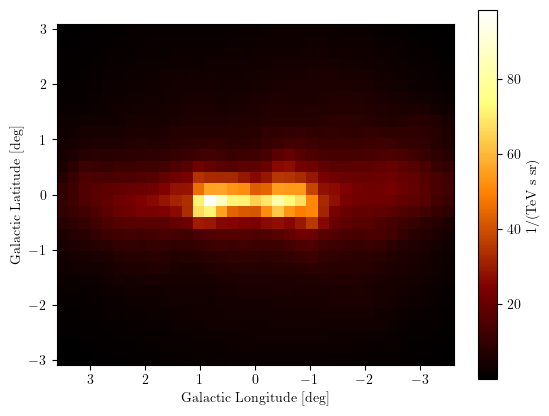

In [44]:
fig, ax = plt.subplots(1,1, dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, spatialplotcombined.T, vmax=spatialplotcombinedmaxvalue, vmin=spatialplotcombinedmaxvalue/1e4, cmap='afmhot')
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.invert_xaxis()
plt.colorbar(label = r"1/(TeV s sr)")
ax.set_aspect(1)

plt.show()

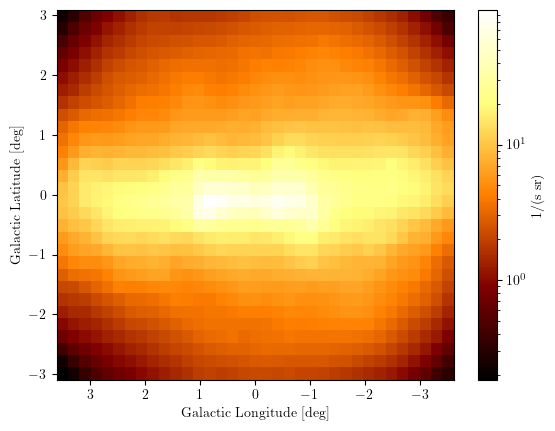

In [45]:
fig, ax = plt.subplots(1,1, dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, spatialplotcombined.T, norm=LogNorm(), cmap='afmhot')
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.invert_xaxis()
plt.colorbar(label = r"1/(s sr)")

plt.show()

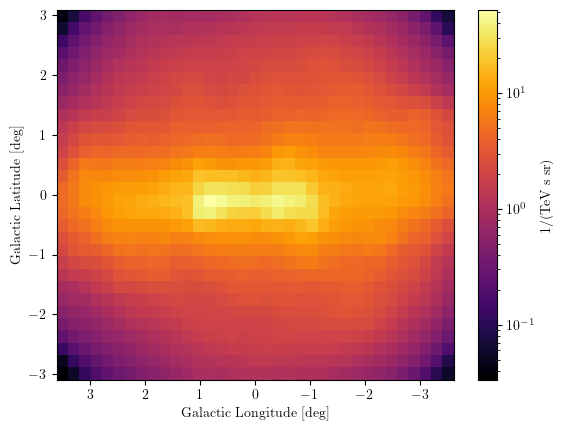

In [46]:
fig, ax = plt.subplots(1,1)
plt.pcolormesh(fermilonaxis, fermilataxis, np.mean(combinedplotmapwithaeff, axis=0).T, norm=LogNorm(), cmap='inferno')
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.invert_xaxis()
plt.colorbar(label = r"1/(TeV s sr)")
plt.show()

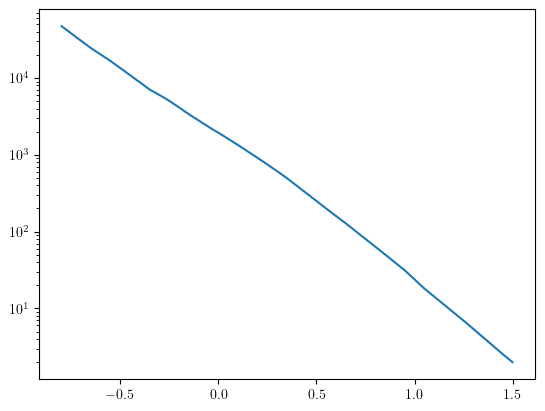

In [47]:
fig, ax = plt.subplots(1,1)
plt.plot(log10eaxistrue, np.sum(combinedplotmapwithaeff, axis=(1,2)))
plt.yscale('log')
plt.show()

In [48]:
np.min(combinedplotmapwithaeff)

0.00021894618728461666

In [49]:
np.save("unnormalised_astrophysicalbackground.npy", combinedplotmapwithaeff)

In [50]:
simps(y=simps(y=simps(y=combinedplotmapwithaeff, x=10**log10eaxistrue, axis=0), x = longitudeaxistrue, axis=0), x=latitudeaxistrue)/1.08e8

3.6540667283369847e-06

In [51]:
fermilataxis

array([-2.98529412, -2.77941176, -2.57352941, -2.36764706, -2.16176471,
       -1.95588235, -1.75      , -1.54411765, -1.33823529, -1.13235294,
       -0.92647059, -0.72058824, -0.51470588, -0.30882353, -0.10294118,
        0.10294118,  0.30882353,  0.51470588,  0.72058824,  0.92647059,
        1.13235294,  1.33823529,  1.54411765,  1.75      ,  1.95588235,
        2.16176471,  2.36764706,  2.57352941,  2.77941176,  2.98529412])

In [52]:
longitudeaxistrue.shape

(35,)

In [53]:
combinedplotmapwithaeff.shape

(231, 35, 30)

In [54]:
simps(y=simps(y=simps(y=combinedplotmapwithaeff, x=10**log10eaxistrue,axis=0), x=longitudeaxistrue, axis=0), x=latitudeaxistrue)*60*60*525/1e8

7.458681005881454

In [55]:
import pandas as pd
data = pd.read_csv("CR_BKG.csv")
data = np.asarray(data)

In [56]:

bkginterp = interpolate.interp1d(x = data[:,0],y = 1.1*data[:,1], bounds_error=False, fill_value="extrapolate", kind='linear')

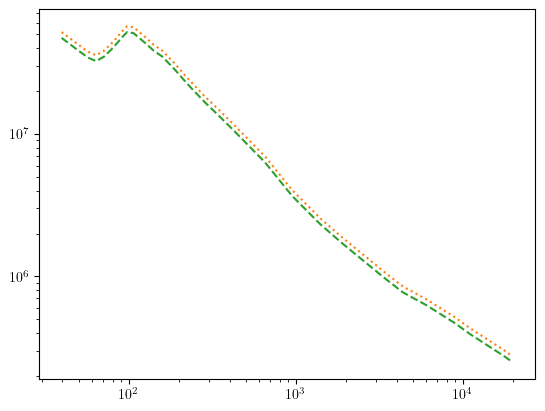

In [57]:
plt.figure()
plt.plot(data[:,0],data[:,1], c='tab:green', ls='--')
plt.plot(data[:,0],bkginterp(data[:,0]), c='tab:orange', ls=':')
plt.loglog()
plt.show()

In [58]:
bkginterp(30),

(array(60993495.83836544),)

In [59]:
gev_energy_range = np.logspace(np.log10(30), np.log10(100000), 55)
gev_energy_range
bkginterpdata = bkginterp(gev_energy_range)

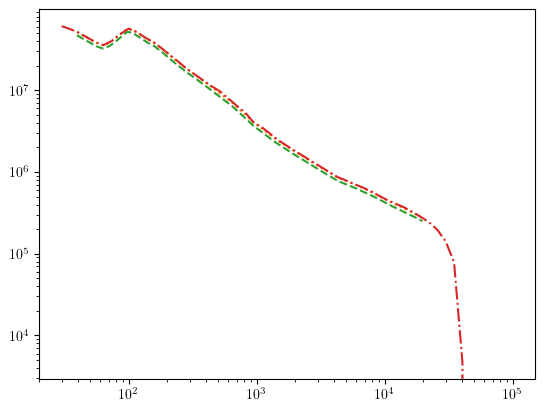

In [60]:
plt.figure()
plt.plot(data[:,0],data[:,1], c='tab:green', ls='--')
plt.plot(data[:,0],bkginterp(data[:,0]), c='tab:orange', ls=':')
plt.plot(gev_energy_range,bkginterpdata, c='tab:red', ls='-.')

plt.loglog()
plt.show()

In [61]:


simps(y=bkginterpdata/gev_energy_range, x=gev_energy_range)/1.08e8

1.0173884220265068

In [62]:
bkginterpdata

array([ 6.09934958e+07,  5.63517756e+07,  5.09576948e+07,  4.46893057e+07,
        3.91491379e+07,  3.56564129e+07,  4.01757839e+07,  4.84631756e+07,
        5.67573635e+07,  5.15634163e+07,  4.42965576e+07,  3.87569973e+07,
        3.26015451e+07,  2.69185285e+07,  2.23233877e+07,  1.83094402e+07,
        1.55500163e+07,  1.31224099e+07,  1.11697573e+07,  9.66317862e+06,
        7.91240369e+06,  6.44517823e+06,  5.32475156e+06,  4.03076768e+06,
        3.51969278e+06,  2.92577948e+06,  2.42878144e+06,  2.08894208e+06,
        1.79544278e+06,  1.55864975e+06,  1.34032184e+06,  1.16480728e+06,
        1.00557188e+06,  8.71887027e+05,  7.92842231e+05,  7.16423674e+05,
        6.50520859e+05,  5.84960383e+05,  5.12804143e+05,  4.53680818e+05,
        4.09070066e+05,  3.70390784e+05,  3.25442109e+05,  2.82937970e+05,
        2.42646528e+05,  1.95824382e+05,  1.41412994e+05,  7.81822489e+04,
        4.70264674e+03, -8.06870147e+04, -1.79917196e+05, -2.95231261e+05,
       -4.29236192e+05, -

In [63]:

from gammapy.astro.darkmatter import (
    profiles,
    JFactory
)

profile = profiles.EinastoProfile()

# Adopt standard values used in HESS
profiles.DMProfile.DISTANCE_GC = 8.5 * u.kpc
profiles.DMProfile.LOCAL_DENSITY = 0.39 * u.Unit("GeV / cm3")

profile.scale_to_local_density()

position = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
geom = WcsGeom.create(skydir=position, 
                      binsz=longitudeaxistrue[1]-longitudeaxistrue[0],
                      width=(longitudeaxistrue[-1]-longitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0], latitudeaxistrue[-1]-latitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0]),
                      frame="galactic")

In [64]:
jfactory = JFactory(
    geom=geom, profile=profile, distance=profiles.DMProfile.DISTANCE_GC
)
jfact = jfactory.compute_differential_jfactor()

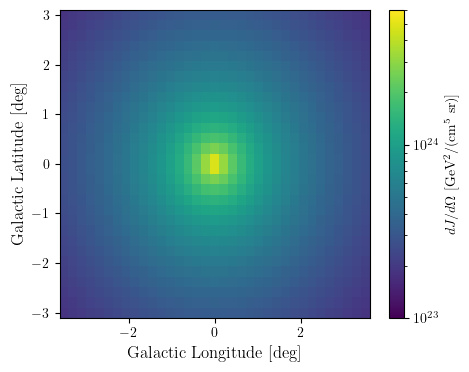

In [95]:
plt.figure(figsize=(5,4))
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, jfact, norm=LogNorm(vmin=1e23, vmax=6e24))
plt.colorbar(label=r'$dJ/d\Omega$ [GeV$^2$/(cm$^5$ sr)]')
plt.xlabel('Galactic Longitude [deg]', size=12)
plt.ylabel('Galactic Latitude [deg]', size=12)
plt.savefig('Figures/Einasto_dJdW.pdf')
plt.show()

In [66]:
jfact.value

array([[1.84534719e+23, 1.93437257e+23, 2.02740852e+23, ...,
        2.02740852e+23, 1.93437257e+23, 1.84534719e+23],
       [1.92023532e+23, 2.01794382e+23, 2.12071189e+23, ...,
        2.12071189e+23, 2.01794382e+23, 1.92023532e+23],
       [1.99624562e+23, 2.10330368e+23, 2.21666635e+23, ...,
        2.21666635e+23, 2.10330368e+23, 1.99624562e+23],
       ...,
       [1.99624562e+23, 2.10330368e+23, 2.21666635e+23, ...,
        2.21666635e+23, 2.10330368e+23, 1.99624562e+23],
       [1.92023532e+23, 2.01794382e+23, 2.12071189e+23, ...,
        2.12071189e+23, 2.01794382e+23, 1.92023532e+23],
       [1.84534719e+23, 1.93437257e+23, 2.02740852e+23, ...,
        2.02740852e+23, 1.93437257e+23, 1.84534719e+23]])

In [67]:
from utils3d import bkgdist

lonmeshtrue, log10emeshtrue, latmeshtrue = np.meshgrid(longitudeaxistrue, log10eaxistrue, latitudeaxistrue)

logbkgpriorvalues = np.squeeze(np.logaddexp(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue),np.log(combinedplotmapwithaeff)))
logbkgpriorvalues.shape

(231, 35, 30)

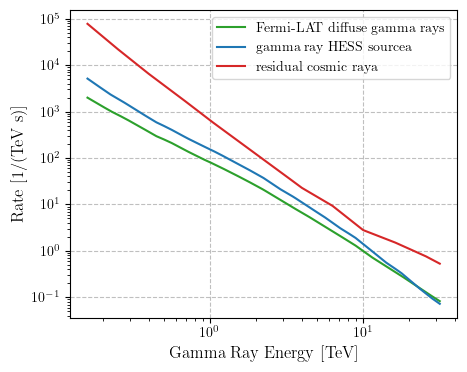

In [89]:
plt.figure(figsize=(5,4))
# plt.plot(log10eaxistrue, np.mean(logbkgpriorvalues, axis=(1,2)), c='tab:blue')
plt.plot(10**log10eaxistrue, simps(y=simps(y=fermifull*aefftable, x=longitudeaxistrue, axis=1), 
                                   x=latitudeaxistrue, axis=1), 
         c="tab:green", label='Fermi-LAT diffuse gamma rays')
plt.plot(10**log10eaxistrue, simps(y=simps(y=np.flip(fullhessdataset, axis=1)*aefftable, x=longitudeaxistrue, axis=1), 
                                   x=latitudeaxistrue, axis=1), 
         c="tab:blue", label='gamma ray HESS sourcea')
plt.plot(10**log10eaxistrue, simps(y=simps(y=np.exp(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)), 
                                                    x=longitudeaxistrue, axis=1), x=latitudeaxistrue, axis=1), 
                                   c="tab:red", label='residual cosmic raya')


plt.loglog()
plt.xlabel(r"Gamma Ray Energy [TeV]", size=12)
plt.ylabel(r"Rate [1/(TeV s)]", size=12)
plt.legend()
plt.grid(ls='--', c='grey', alpha=0.5)
plt.savefig('Figures/integrated_bkg_spectra.pdf')
plt.show()

In [69]:
from utils3d import bkgfull

In [70]:
bkgfull.evaluate(energy=10**0*u.TeV, fov_lon=1.0*u.deg, fov_lat=1.0*u.deg).to(1/(u.TeV*u.s*u.sr))

<Quantity 116.55200141 1 / (s sr TeV)>